## 3546 Deep Learning - Term Project - Summer 2024
## By: Rojean Noorinayer, Marco Hening-Tallarico, and Matt Athayde




#1. Introduction

***
\

- In this project we created a text generation model using a `Bidirectional LSTM (Long Short-Term Memory)` architecture.
- The model was trained on a dataset containing 5,000 BBC news articles, focusing on generating synthetic news articles based on specific input text.




##Significance:

- This project demonstrates the capability of machine learning models, specifically deep learning techniques like LSTM. Some use cases may include:
    - `Content Creation`: Automating the generation of articles, summaries, or creative writing.
    - `Conversational Agents`: Enhancing the capabilities of chatbots and virtual assistants by enabling them to generate more contextually relevant and coherent responses.
    - `Data Augmentation`: Creating synthetic text data to enhance the training datasets for other machine learning models.





# 2. Get Data

***

### Data
- We used Kaggle’s BBC news articles dataset.
- 4 columns: category, filename, title, content
- 5,000 rows

\

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
import tensorflow.keras.utils as ku
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Data source: https://www.kaggle.com/datasets/hgultekin/bbcnewsarchive
# Specify the separator as '\t' for tab-separated values
data = pd.read_csv("/content/drive/MyDrive/Deep Learning Course/Term Project/bbc-news-data.csv", sep='\t')


Mounted at /content/drive


# 3. Data Exploration

***
\

###Understanding the Data
Before jumping into building the model, we wanted to understand the structure and content of the dataset. This included examining the distribution of words, sentence lengths, the presence of special characters, and common phrases. Understanding these aspects helps us in tailoring preprocessing steps like tokenization, stop-word removal, and lemmatization to the specific dataset.

\

###Identifying Patterns and Anomalies
Data exploration also helped us identify patterns, such as frequent terms or phrases, which can be important features for the model. It also helps in detecting anomalies like outliers, missing data, or imbalances in class distribution, which can affect model performance.

\

###Characteristics of our data
- `Diversity`: It provides a wide range of topics and writing styles, which is beneficial for training a model to generate diverse and coherent text.
- `Relevance`: The dataset is relevant to the domain of news generation, which was the intended application for the model.
- `Availability`: The dataset is publicly available and commonly used in NLP (Natural Language Processing) tasks, making it a suitable choice for this project.

\


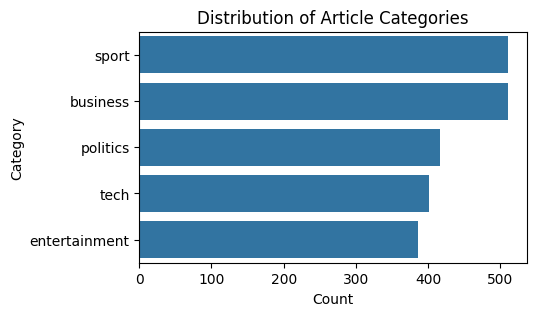

In [ ]:
# Plot the distribution of article categories
plt.figure(figsize=(5, 3))
sns.countplot(y=data['category'], order=data['category'].value_counts().index)
plt.title('Distribution of Article Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()


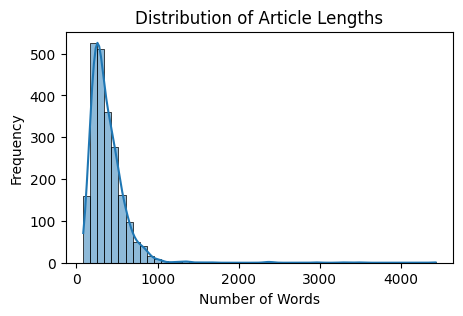

In [ ]:
# Plot the distribution of article lengths
article_lengths = data['content'].apply(lambda x: len(x.split()))
plt.figure(figsize=(5, 3))
sns.histplot(article_lengths, bins=50, kde=True)
plt.title('Distribution of Article Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# only keep rows with category = tech
# this is due to our processing limitation.
# Even with google colab pro the model size of the dataset grows exponentially
# and the session runs out of RAM immediately

data = data[data['category'] == 'tech']
data.head()

,category,filename,title,content
1824,tech,001.txt,Ink helps drive democracy in Asia,"The Kyrgyz Republic, a small, mountainous sta..."
1825,tech,002.txt,China net cafe culture crackdown,"Chinese authorities closed 12,575 net cafes i..."
1826,tech,003.txt,Microsoft seeking spyware trojan,Microsoft is investigating a trojan program t...
1827,tech,004.txt,Digital guru floats sub-$100 PC,"Nicholas Negroponte, chairman and founder of ..."
1828,tech,005.txt,Technology gets the creative bug,The hi-tech and the arts worlds have for some...


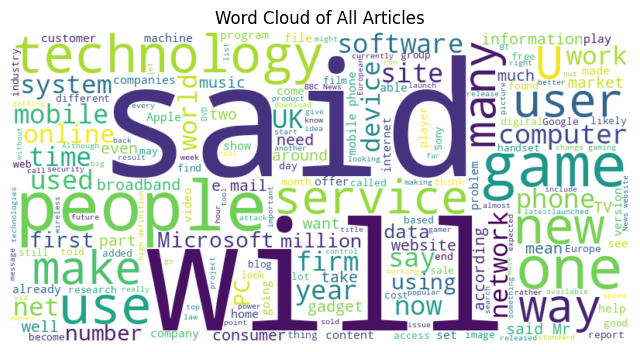

In [ ]:
# Generate a word cloud for the entire content
all_text = ' '.join(data['content'].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Articles')
plt.show()


# 4. Data Preprocessing

***
\

Since real world text data usually contains noise such as typos, irrelevant information, or inconsistencies, cleaning the data helps in reducing noise, which in turn improves model accuracy.

- `Reduce dimensionality`: We reduced the dimentionality of the data by dropping the unnecessary columns. In the previous step, we also reduced the numerosity.

- `Remove special characters`: We removed all the special characters from the data as it was irrelevant at this stage of the project.

- `Change all characters to lowercase`: we normalized the text reducing the variability of the data.

- `Tokenization`: Tokenization breaks down text into meaningful units (tokens) like words or subwords allows for better feature extraction. With proper tokenization we made sure that the text is represented in a way that the model can effectively process and learn from.

- `Sequencing`: We converted sentences into numerical values based on the word-key pairs.
- `Padding`: We padded the text to make sure all the entries in the dataset have the same length.

\

In [ ]:
# only keep the content column
data = data['content']
data.head()

,content
1824,"The Kyrgyz Republic, a small, mountainous sta..."
1825,"Chinese authorities closed 12,575 net cafes i..."
1826,Microsoft is investigating a trojan program t...
1827,"Nicholas Negroponte, chairman and founder of ..."
1828,The hi-tech and the arts worlds have for some...


In [ ]:
# join all the rows in the dataset and merge them into one variable
# We did because there was no need for the news article categories
# after only keeping tech articles, it made sense for the ease of handeling the data to merge everything

text = ' '.join(data)

# View the first 100 characters
print(text[:100])

 The Kyrgyz Republic, a small, mountainous state of the former Soviet republic, is using invisible i


In [ ]:
# Define the Data cleaning function

def clean_text(text):
    # Remove non-letters except for .
    text = re.sub("[^a-zA-Z.]", " ", text)
    # Convert to lowercase and split into sentences
    sentences = text.lower().split(".")
    return sentences

In [ ]:
# Apply the cleaning function on the dataset
corpus = clean_text(text)

# View the first 15 cleaned sentences
corpus[:15]

[' the kyrgyz republic  a small  mountainous state of the former soviet republic  is using invisible ink and ultraviolet readers in the country s elections as part of a drive to prevent multiple voting',
 '  this new technology is causing both worries and guarded optimism among different sectors of the population',
 ' in an effort to live up to its reputation in the     s as  an island of democracy   the kyrgyz president  askar akaev  pushed through the law requiring the use of ink during the upcoming parliamentary and presidential elections',
 ' the us government agreed to fund all expenses associated with this decision',
 '  the kyrgyz republic is seen by many experts as backsliding from the high point it reached in the mid     s with a hastily pushed through referendum in       reducing the legislative branch to one chamber with    deputies',
 ' the use of ink is only one part of a general effort to show commitment towards more open elections   the german embassy  the soros foundati

In [ ]:
# How many full sentences are there in our current data set
len(corpus)

9960

### Tokenization

Tokenaization assigns a numerical value to each word. We then visualize this below.

In [ ]:
# Fitting the Tokenizer on the Corpus
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

# Vocabulary count of the corpus
total_words = len(tokenizer.word_index)

print("Total Words:", total_words)

Total Words: 11593


In [ ]:
tokenizer.word_index['i']

54

### Sequencing

We are converting sentences into numerical values based on the word-key pairs.

In [ ]:
# Converting the text into embeddings
# ngram sequencing is an inmportant step for text generation

input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]

    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)




### Padding

We want ot make sure that all the entries in the dataset have the same length.

***This step makes the dataset extremely large***

In [ ]:
# We need to find the longest sequence length. this is needed for padding
# Because we are adding 0s until the length of the longest sequence is reached.

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))


In [ ]:
# Let's see what the sequences look like
input_sequences

array([[    0,     0,     0, ...,     0,     1,  3872],
       [    0,     0,     0, ...,     1,  3872,  1760],
       [    0,     0,     0, ...,  3872,  1760,     5],
       ...,
       [    0,     0,     0, ...,    70,    23,     1],
       [    0,     0,     0, ...,    23,     1,   433],
       [    0,     0,     0, ...,     1,   433, 11593]], dtype=int32)

### Prepare Features and labels

In [ ]:
# create feature-label pairs - this dataset is what we use to train the models

predictors, label = input_sequences[:, :-1], input_sequences[:, -1]

# convert the labels to categorical values

label = ku.to_categorical(label, num_classes=total_words+1)

# 5. Build the Model

***
\
- We used a Bidirectional LSTM model for text generation. LSTMs are a type of recurrent neural network (RNN) that are particularly well-suited for sequence prediction problems due to their ability to remember long-term dependencies. The bidirectional aspect allows the model to learn from both past and future contexts, improving the quality of the generated text.



- We have done Hyperparameter tuning based on the below HPs. We wanted to experiment with more HPs and different values, However, due to our resource limitations we have stoped at the model below.
    - `dropout rate`: 0.2, 0.3
    - `activation function`: relu, rmsprop
    - `neuron size`: 128, 150, 256

\


In [ ]:
from keras.callbacks import EarlyStopping

# Building a Bi-Directional LSTM Model
model = Sequential()
model.add(Embedding(total_words+1, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(256, return_sequences=True))) #changed from 150
model.add(Dropout(0.3)) # changed from 0.2
model.add(LSTM(100))
model.add(Dense(total_words+1//2, activation='relu', kernel_regularizer=regularizers.l2(0.02))) # changed from 0.01
model.add(Dense(total_words+1, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# View model architecture
print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


# 6. Train the Model

***
\

To pick the best model we set an early stopping condition on validation accuracy with a patience of 3. This means the model will stop traning if validation accuracy decreases for 3 consecutive epochs. After this happens we will stick with the model with the highest validation accuracy.

In [ ]:
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# Train the model with early stopping
history = model.fit( predictors, label, batch_size=128, epochs=80, shuffle=True, validation_split=0.2, callbacks=[early_stopping], verbose=1)


Epoch 1/80
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 192s 151ms/step - accuracy: 0.0565 - loss: 7.2732 - val_accuracy: 0.0782 - val_loss: 6.8083
Epoch 2/80
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 177s 149ms/step - accuracy: 0.0823 - loss: 6.5395 - val_accuracy: 0.0943 - val_loss: 6.7252
Epoch 3/80
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 177s 149ms/step - accuracy: 0.1016 - loss: 6.3624 - val_accuracy: 0.1018 - val_loss: 6.5730
Epoch 4/80
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 177s 148ms/step - accuracy: 0.1125 - loss: 6.1921 - val_accuracy: 0.1112 - val_loss: 6.4997
Epoch 5/80
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 177s 148ms/step - accuracy: 0.1203 - loss: 6.0709 - val_accuracy: 0.1178 - val_loss: 6.4491
Epoch 6/80
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 177s 148ms/step - accuracy: 0.1305 - loss: 5.9393 - val_accuracy: 0.1205 - val_loss: 6.4463
Epoch 7/80
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 177s 148ms/step - accuracy: 0.1379 - loss: 5.8194 - val_accuracy: 0.1297 - val_loss: 6.3854
Epoch 8/80
1194/1194 ━━━━━━━━━━━━━━━━━━━━ 177s 148ms/step - ac

In [ ]:
#save the model

model.save("/content/drive/MyDrive/Deep Learning Course/Term Project/Rojeans_generative_model2.keras")

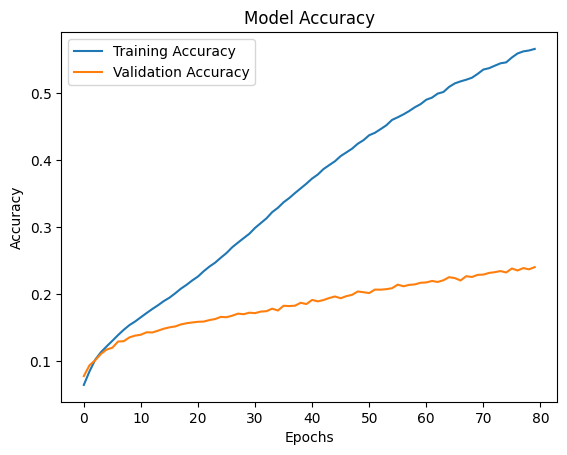

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='upper left')
plt.show()

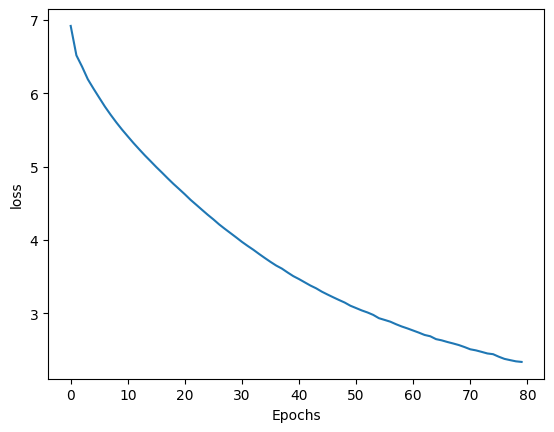

In [ ]:
# Visualize the loss
def plot_graph(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()
plot_graph(history, 'loss')


# 7. Generate and Test

***
\

At this stage, we created a generator function to generate synthetic newspaper articles based on the model we constructed and trained in the previous steps.

We give the generator a phrase or a collection of words and the length of the article, and the function generated the text based on that input.

In [ ]:
def generate_text(seed_text, next_words):

    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences(
            [token_list], maxlen=max_sequence_len-1,
            padding='pre')
        predictions = model.predict(token_list, verbose=0)[0]
        predicted = np.random.choice(len(predictions), p=predictions / np.sum(predictions))

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break

        seed_text += " " + output_word

    return seed_text

In [ ]:
generated = generate_text("artificial intelligence", 100)

print(generated)

artificial intelligence need like gamers who tried to make search sites offering a bike on depth like video on their home devices on their home computer servers that clicked while hurricane which can be on cameras on radio and music players are used to help pcs in the more critical said john fogg shows from the things you need to be tightly blizzard to get internal porn in the net for games people they have come about before mr wong told the bbc news website according to its way only many people were having to do anything to add their music to


In [ ]:
print(generate_text("new technology", 100))


new technology has been downloaded with pre prepared game crime which flashes on bloggers which are not immediately at setting up playing em on programs of celebrities work the gadget group is undergoing a legitimate way to create a service that lets people receive risks space and they are going to want of pirated copies devices constantly use their data on titles such as suprnova and aol felony copyright infringement and those in the next generation market will be done in to english or commercial silicon said dr nielsen has this was a big draw for personal cost than conflicts of interest


In [ ]:
print(generate_text("advancements in hardware", 100))

advancements in hardware has been developed by vodafone publishes this ruin malicious programs from fashion or cps services and the patents is to wear about alive firms to ensure not run out of george mason s managing director david rubin attackers such as the government in april and telefonica peter stollenmayer for some respects used without a case shortage of blogs and owners like an obe in the plants or the legal web library also had this new principles explained ian r which general sees restricting or rounds for education and fluid to see what they are doing he added and new views


In [ ]:
print(generate_text("faster processing time", 100))

faster processing time at and sold these fraudulent magazines of firms were small than the main factors of the service receiving infected on the results go to an international pc experience and the sets can be taken in putting or selling over a brussels environment to hp company which it could kilometres licence properties between shops from web journals especially the incoming waves of japanese backgrounds managing service came in india from choice for its pilots which was easier said dominic hirsch managing technology it is closer to tara for spammers keen phpbb software rose by to your denial of pc g casio


# 8. Challengers, Learnings, and Next Steps

***
\

###Challenges and Learnings
- `Recourse Limitation`: The most significant challenge of this project was our **Resource limitation** mainly RAM and GPU. After the padding step, the size of the dataset grew exponentially.

- `Complexity of Language`: Generating grammatically correct and contextually appropriate text remains a challenge, as the model sometimes produced awkward phrases or repeated words.

\

###Next Steps

- `Model Tuning`: We really wanted to experiment with different architectures (e.g., Transformer models like BERT and GPT) and hyperparameters to improve text quality. Unfortunately loading these models was very resource intensive and we could not make it work. But give more computational power, we would love to explore other models and HPs.
- `Data Augmentation`: Incorporate additional datasets or data augmentation techniques to provide more diverse training examples.
- `Evaluation`: Implement more rigorous evaluation metrics, such as BLEU or ROUGE scores, to quantitatively assess the quality of the generated text.
